In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints.toy as toy
import pints
import numpy as np
import logging
import math
import sys
from numpy import inf
import copy 
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
import matplotlib.transforms as transforms
from logisticdraw import draw_cma_evolution
from logisticdraw import draw_dist_model_evolution
from logisticdraw import model_dict
from logisticdraw import draw_boundaries
import logisticdraw as ld

In [2]:
class IGOCMAFake(pints.PopulationBasedOptimiser):
    """
    Finds the best parameters using the CMA-ES method described in [1, 2].

    CMA-ES stands for Covariance Matrix Adaptation Evolution Strategy, and is
    designed for non-linear derivative-free optimization problems.

    *Extends:* :class:`PopulationBasedOptimiser`

    [1] https://arxiv.org/pdf/1604.00772.pdf

    [2] Hansen, Mueller, Koumoutsakos (2006) Reducing the time complexity of
    the derandomized evolution strategy with covariance matrix adaptation
    (CMA-ES).

    Important note: The parameter parent_pop_size is the mu in the papers. It represents the size of a parent population
        used to update our paramters.

    """

    def __init__(self, x0, sigma0=0.5, boundaries=None):
        super(IGOCMAFake, self).__init__(x0, sigma0, boundaries)

        # Set initial state
        self._running = False
        self._ready_for_tell = False

        # Best solution found
        self._xbest = pints.vector(x0)
        self._fbest = float('inf')

        # Python logger
        self._logger = logging.getLogger(__name__)

        self._printing = False

        self._counter = 0

    def set_print(self, v):
        self._printing = v

    def ask(self):
        """ See :meth:`Optimiser.ask()`. """
        # Initialise on first call
        if not self._running:
            self._initialise()

        # Ready for tell now
        self._ready_for_tell = True

        # Create new samples
        self._zs = np.array([np.random.multivariate_normal([0] * self._n_parameters, np.identity(self._n_parameters))
                             for _ in range(self._population_size)])

        self._ys = np.array([self._B.dot(self._D).dot(z) for z in self._zs])

        self._xs = np.array([self._x0 + self._sigma0 * self._ys[i]
                             for i in range(self._population_size)])

        if self._manual_boundaries:
            if isinstance(self._boundaries, pints.RectangularBoundaries):
                upper = self._boundaries.upper()
                lower = self._boundaries.lower()
                for i in range(len(self._xs)):
                    for j in range(len(self._xs[0])):
                        if self._xs[i][j] > upper[j] or self._xs[i][j] < lower[j]:
                            self._xs[i][j] = lower[j] + ((self._xs[i][j] - lower[j]) % (upper[j] - lower[j]))
                    self._ys[i] = (self._xs[i] - self._x0) / self._sigma0
                    self._zs[i] = np.linalg.inv(self._D).dot(np.linalg.inv(self._B)).dot(self._ys[i])
        
        self._user_xs = self._xs
        self._user_zs = self._zs
        self._user_ys = self._ys

        # Set as read-only and return
        self._user_xs.setflags(write=False)
        return self._user_xs

    def fbest(self):
        """ See :meth:`Optimiser.fbest()`. """
        if not self._running:
            return float('inf')
        return self._fbest

    def set_pop(self, n_pop):
        self._population_size = n_pop
    
    def _initialise(self):
        """
        Initialises the optimiser for the first iteration.
        """
        assert (not self._running)

        # Set boundaries, or use manual boundary checking
        self._manual_boundaries = False
        self._boundary_transform = None
        if isinstance(self._boundaries, pints.RectangularBoundaries):
            self._boundary_transform = pints.TriangleWaveTransform(
                self._boundaries)
            self._manual_boundaries = True

        elif self._boundaries is not None:
            self._manual_boundaries = True
           
        # CMA-ES wants a single standard deviation as input, use the smallest
        # in the vector (if the user passed in a scalar, this will be the
        # value used). THIS IS ALSO THE STEP SIZE
        self._sigma0 = np.min(self._sigma0)

        # Eigenvectors
        self._B = np.identity(self._n_parameters)
        # SquareRoot of Diagnonal of EigenValues
        self._D = np.identity(self._n_parameters)
        # Cov-matrix (also identity)
        self._C = self._B.dot(self._D).dot(self._D.T).dot(self._B.T)

        # Parent generation population size
        # Not sure if the limitation to dim is good
        # This limitation is supposed to prevent a mistake in the update of the Covariance
        # matrix (C) with the rank mu update
        self._parent_pop_size = self._population_size // 2

        # Weights, all set equal for the moment (not sure how they are actually defined)
        # Sum of all positive weights should be 1
        self._W = [math.log((self._population_size + 1) / 2.) - math.log(i) for i in
                   range(1, self._population_size + 1)]

        # Inverse of the Sum of the first parent weights squared (variance effective selection mass)
        self._muEff = np.sum(self._W[:self._parent_pop_size]) ** 2 / np.sum(np.square(self._W[:self._parent_pop_size]))

        # Inverse of the Sum of the last weights squared (variance effective selection mass)
        self._muEffMinus = np.sum(self._W[self._parent_pop_size:]) ** 2 / np.sum(
            np.square(self._W[self._parent_pop_size:]))

        # cumulation, evolution paths, used to update Cov matrix and sigma)
        self._pc = np.zeros(self._n_parameters)
        self._psig = np.zeros(self._n_parameters)

        # learning rate for the mean
        self._cm = 1

        # Decay rate of the evolution path for C
        self._ccov = (4 + self._muEff / self._n_parameters) / (
                self._n_parameters + 4 + 2 * self._muEff / self._n_parameters)

        # Decay rate of the evolution path for sigma
        self._csig = (2 + self._muEff) / (self._n_parameters + 5 + self._muEff)

        # See rank-1 vs rank-mu updates
        # Learning rate for rank-1 update
        self._c1 = 2 / ((self._n_parameters + 1.3) ** 2 + self._muEff)

        # Learning rate for rank-mu update
        self._cmu = min(2 * (self._muEff - 2 + 1 / self._muEff) / ((self._n_parameters + 2) ** 2 + self._muEff)
                        , 1 - self._c1)

        # Damping of the step-size (sigma0) update
        self._dsig = 1 + 2 * max(0., math.sqrt((self._muEff - 1) / (self._n_parameters + 1)) - 1) + self._csig

        # Parameters from the Table 1 of [1]
        alpha_mu = 1 + self._c1 / self._cmu
        alpha_mueff = 1 + 2 * self._muEffMinus / (self._muEff + 2)
        alpha_pos_def = (1 - self._c1 - self._cmu) / (self._n_parameters * self._cmu)

        # Rescaling the weights
        sum_pos = sum([self._W[i] if self._W[i] > 0 else 0 for i in range(self._population_size)])
        sum_neg = sum([self._W[i] if self._W[i] < 0 else 0 for i in range(self._population_size)])

        self._W = [self._W[i] / sum_pos
                   if self._W[i] >= 0
                   else self._W[i] * min(alpha_mu, alpha_mueff, alpha_pos_def) / -sum_neg
                   for i in range(self._population_size)]

        # CMAES always seeds np.random, whether you ask it too or not, so to
        # get consistent debugging output, we should always pass in a seed.
        # Instead of using a fixed number (which would be bad), we can use a
        # randomly generated number: This will ensure pseudo-randomness, but
        # produce consistent results if np.random has been seeded before
        # calling.
        self._seed = 2 ** 31
        #np.random.seed(self._seed)

        # Update optimiser state
        self._running = True

    def name(self):
        """ See :meth:`Optimiser.name()`. """
        return 'Covariance Matrix Adaptation Evolution Strategy (CMA-ES)'

    def running(self):
        """ See :meth:`Optimiser.running()`. """
        return self._running

    def stop(self):
        diag_D = np.diagonal(self._D)
        # We use the condition number defined in the pycma code at
        # https://github.com/CMA-ES/pycma/blob/3abf6900e04d0619f4bfba989dde9e093fa8e1ba/cma/evolution_strategy.py#L2965
        if (np.max(diag_D) / np.min(diag_D)) ** 2 > 1e14:
            return 'Ill-conditionned covariance matrix'
        return False

    def _suggested_population_size(self):
        """ See :meth:`Optimiser._suggested_population_size(). """
        return 4 + int(3 * np.log(self._n_parameters))

    def tell(self, fx):
        """ See :meth:`Optimiser.tell()`. """
        if not self._ready_for_tell:
            raise Exception('ask() not called before tell()')
        self._ready_for_tell = False

        self._counter += 1

        fx[fx == np.inf] = sys.maxsize

        # Get the best xs according to the fx results
        order = np.argsort(fx)
        xs_bests = np.array(self._user_xs[order])
        ys_bests = np.array(self._user_ys[order])  # = np.array((xs_bests - self._x0) / self._sigma0)

        # Update the mean
        self._x0 = self._x0 + self._cm * np.sum(np.multiply((xs_bests[:self._parent_pop_size] - self._x0).T,
                                                            self._W[:self._parent_pop_size]).T, 0)

        # Update the Covariance matrix:
        # First carry on some of the previous value
        # Add the rank-mu update
        rankmu = self._cmu * np.sum(np.multiply(np.array([np.outer(y, y) - self._C for y in ys_bests]).T,
                                                self._W).T, 0)
        self._C = self._C  + rankmu

        # Update B and D
        self._C = np.triu(self._C) + np.triu(self._C, 1).T
        [eigenvals, self._B] = np.linalg.eigh(self._C)

        if self.stop():
            return False

        self._D = np.sqrt(np.diag(eigenvals))

        if self._fbest > fx[order[0]]:
            self._fbest = fx[order[0]]
            self._xbest = xs_bests[0]

    def print_all_info(self):
        print("parents weights ", self._W[:self._parent_pop_size])
        print("other weights", self._W[self._parent_pop_size:])
        print("c1", self._c1)
        print("cmu", self._cmu)
        print("Mean", self._x0)
        print("Covariance matrix", self._C)
        print("B or EIGENVECTORS", self._B)
        print("D", self._D)

    def rankmu(self):
        return self._rankMu_update

    def cov(self):
        return self._C

    def mean(self):
        return self._x0

    def xbest(self):
        """ See :meth:`Optimiser.xbest()`. """
        if self._running:
            return np.array(self._xbest, copy=True)
        return np.array([float('inf')] * self._n_parameters)

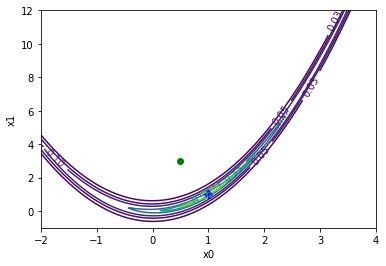

In [3]:
xmax=4
xmin=-2
ymax=12
ymin=-1
score = model_dict['Rosenbrock']['model'] 
levels = np.concatenate((np.linspace(0, 0.05, 3), np.linspace(0.1, 1, 5))) 

ax = plt.subplot()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlabel("x0")
plt.ylabel('x1')
plt.plot(1,1,'bD')
plt.plot(0.5,3,'go')
cp =ld.add_contour(xmax, xmin, ymax, ymin, score, levels, is_dist=True )
ax.clabel(cp, inline=1, fontsize=10, fmt='%1.2f')
plt.savefig('ROSENBROCK.pdf')
plt.show()

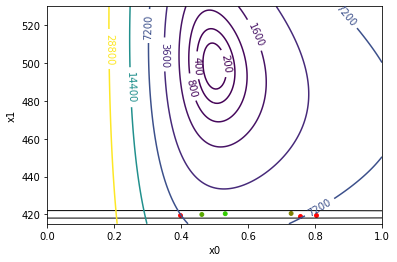

Iteration # 0
5.6674356736045356e-08


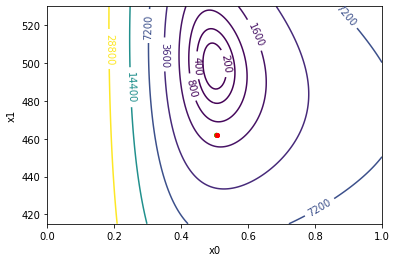

Iteration # 499
4.693979094904433e-08


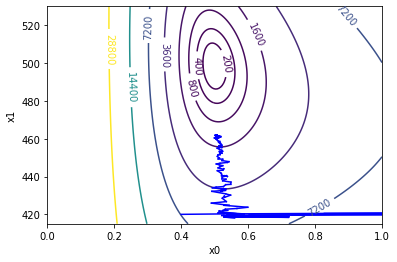

In [4]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, 3,fakeIGO=True)

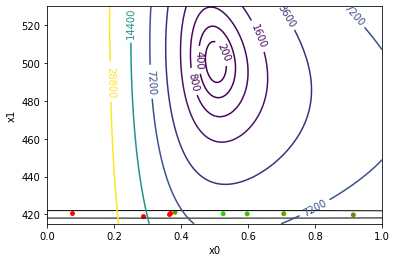

Iteration # 0
5.6720605579500236e-08


/home/naunauyoh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in sqrt


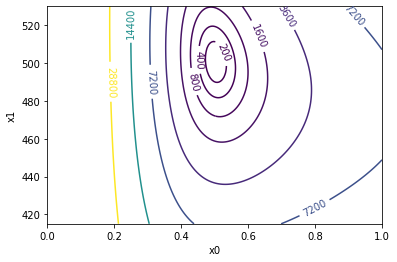

Iteration # 199
5.568551249941765e-08


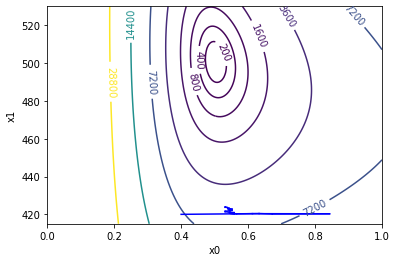

In [5]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 10
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True ,iterations=200)

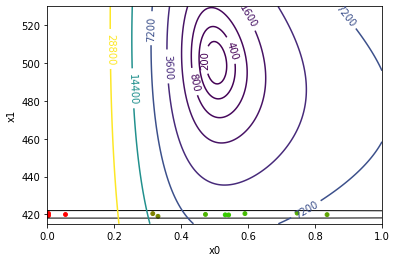

Iteration # 0
5.6835399007124855e-08


/home/naunauyoh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in sqrt


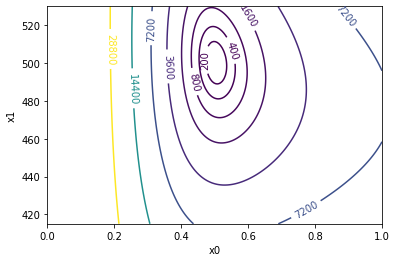

Iteration # 249
4.0009685862422544e-08


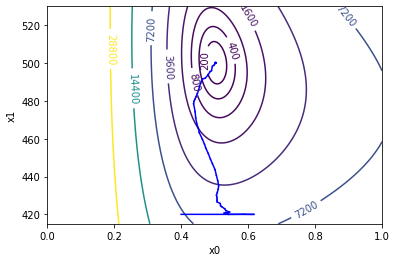

In [6]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 20
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=250)

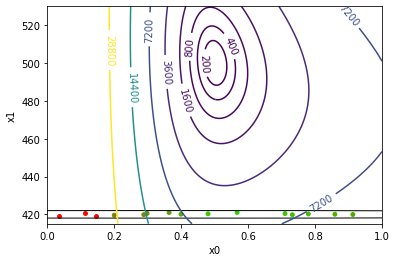

Iteration # 0
5.650633662882599e-08


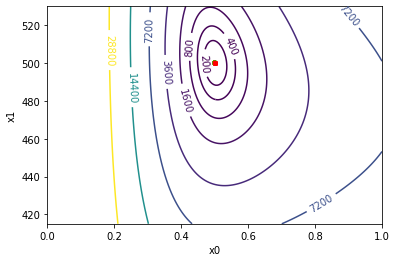

Iteration # 149
4.002417719635606e-08


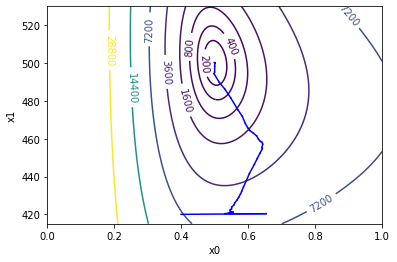

In [7]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 30
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=150)

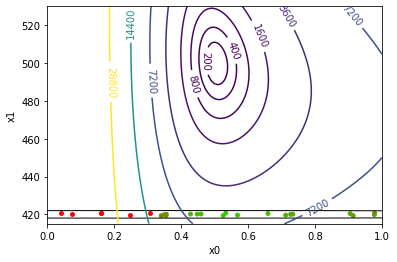

Iteration # 0
5.6580316946458835e-08
Error occured


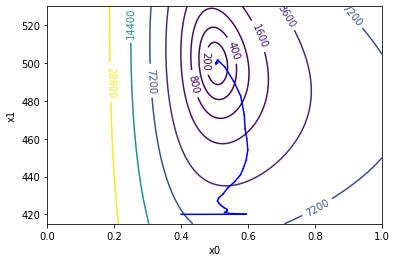

In [8]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 40
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=75)

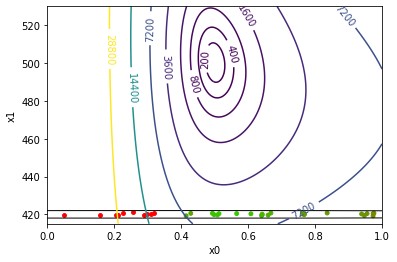

Iteration # 0
5.665909377565605e-08


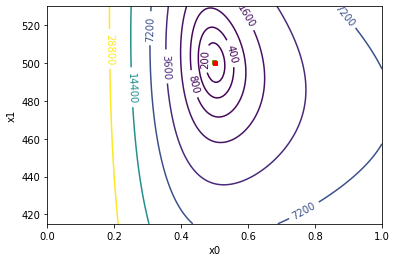

Iteration # 74
3.9996582581971215e-08


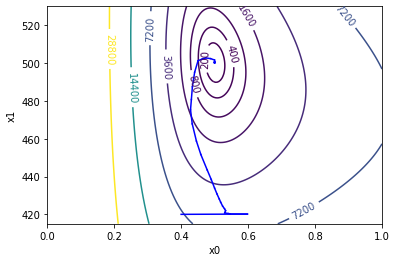

In [9]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 50
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=75)

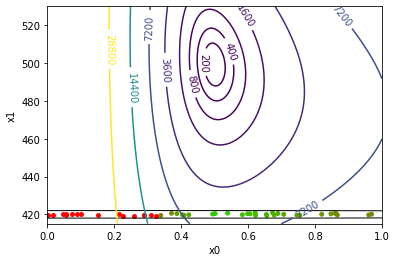

Iteration # 0
5.659787823461179e-08


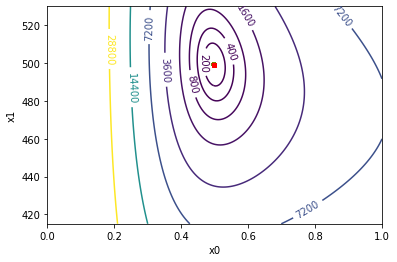

Iteration # 74
4.016343005676043e-08


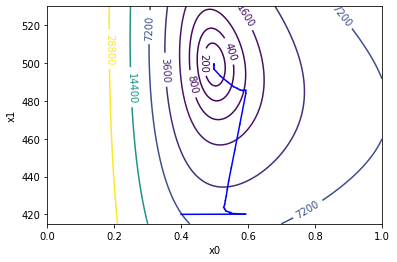

In [10]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 60
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=75)

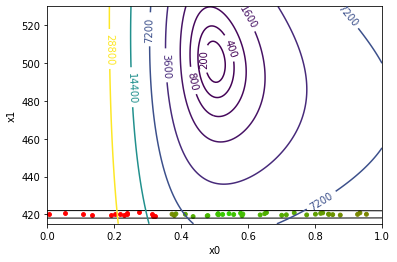

Iteration # 0
5.6674689286649746e-08


In [ ]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 70
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=50)

In [ ]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 90
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=50)

In [ ]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 95
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=35)

In [ ]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 99
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=35)

In [ ]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
pop = 100
cma.set_pop(pop)
draw_cma_evolution(value['model'], value['real_parameters'], value['times'], cma, pop // 2, fakeIGO=True, iterations=35)

In [ ]:
value = model_dict['Logistic']
x0 = value['x0']
cma = IGOCMAFake(x0)
boundaries = pints.RectangularBoundaries([0.35, 419.5], [2.5, 428])
cma_bound = IGOCMAFake(x0, boundaries=boundaries)
pop = 100
cma.set_pop(pop)
cma_bound.set_pop(pop)
draw_boundaries(value['model'], value['real_parameters'], value['times'], cma_bound, cma, pop // 2, boundaries, "log")